# CLASIFICACIÓN DE RAZAS DE PERROS

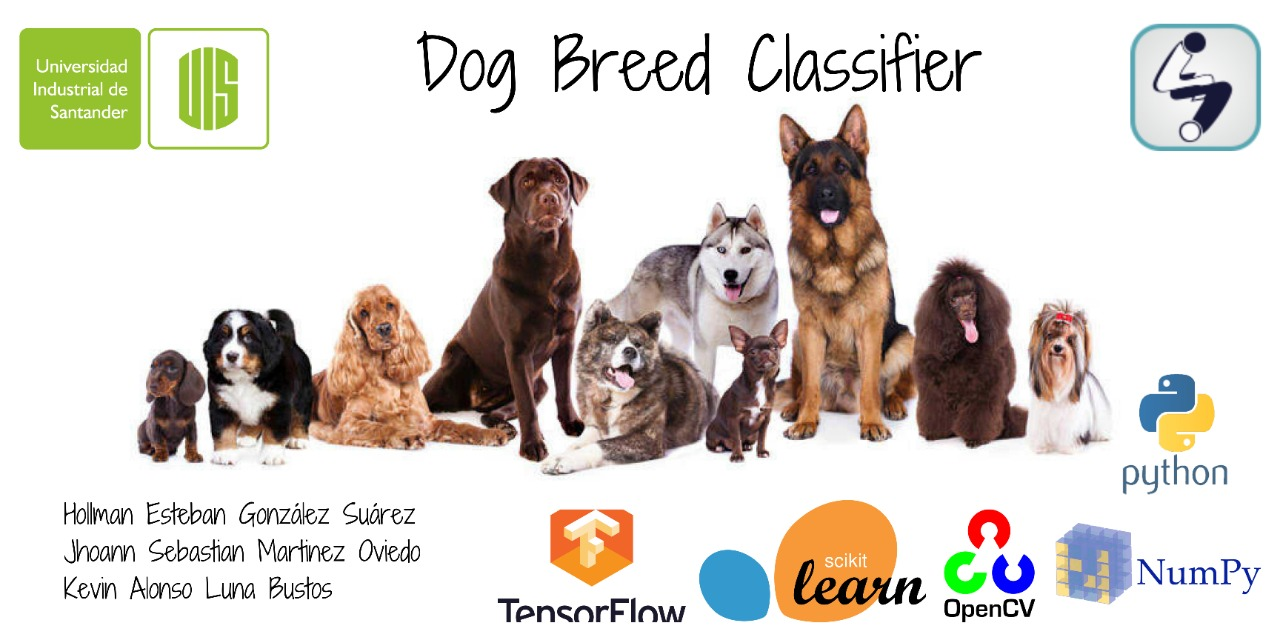

# **Integrantes:**

1. Jhoann Sebastian Martinez Oviedo 2171995
2. Hollman Esteban González Suárez 2172002
3. Kevin Alonso Luna Bustos 2172022

# Contexto
El conjunto de datos de Stanford Dogs Dataset contiene imágenes de 120 razas de perros de todo el mundo. Este conjunto de datos se ha creado utilizando imágenes y anotaciones de ImageNet para la tarea de categorización detallada de imágenes. Originalmente se recopiló para la categorización de imágenes de grano fino, un problema desafiante ya que ciertas razas de perros tienen características casi idénticas o difieren en color y edad.

# Contenido
Número de categorías: 120
Número de imágenes: 20.580
Anotaciones: etiquetas de clase, cuadros delimitadores

# Agradecimientos
La fuente de datos original se encuentra en http://vision.stanford.edu/aditya86/ImageNetDogs/ y contiene información adicional sobre las divisiones de entrenamiento / prueba y los resultados de referencia.

# DATASET Usado
Se uso la versión del dataset publicado por Dog-breed-identification en la plataforma de Kaggle.

In [1]:
#@title 1. MONTAR EL DRIVE  { display-mode: "form" }
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Proyecto_IA')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Proyecto_IA


In [2]:
#@title Importar librerias
from google.colab import files
import matplotlib.pyplot as plt
import os,shutil,math,scipy,cv2
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import random as rn
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom

from keras.utils.np_utils import to_categorical
from keras import layers
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils import model_to_dot, plot_model
from keras.preprocessing.image import img_to_array


# **DATASET**

In [3]:
#Dirección de los ficheros
labels = pd.read_csv('dog-breed-identification/labels.csv')
train_dir = 'dog-breed-identification/train'
test_dir = 'dog-breed-identification/test'

In [4]:
#Razas de perros
dogs_breeds = ['scottish_deerhound','maltese_dog','entlebucher','pomeranian','labrador_retriever','basenji','airedale','leonberg','blenheim_spaniel','siberian_husky']
D = []
Z = []
imgsize = 150   
def label_assignment(img):
    img = img.rsplit( ".", 1 )[ 0 ]
    label = "".join(labels[labels.id == img].breed.unique())
    return label

def resize_dataset(data_dir):
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img)
        if label in dogs_breeds:
            path = os.path.join(data_dir,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(imgsize,imgsize))
            D.append(np.array(img))
            Z.append(str(label))

        
resize_dataset(train_dir)
resize_dataset(test_dir)

100%|██████████| 10357/10357 [00:13<00:00, 780.11it/s]


# Cantidad de Imagenes de Cada Raza Seleccionada

- scottish_deerhound
- maltese_dog
- entlebucher
- pomeranian
- labrador_retriever
- basenji
- airedale
- leonberg
- blenheim_spaniel
- siberian_husky 

In [ ]:
df = pd.DataFrame()
df['breed'] = Z
print(df['breed'].value_counts())
print('\n#Total Load Image:   '+str(len(df.breed)))

scottish_deerhound    126
maltese_dog           117
entlebucher           115
pomeranian            111
basenji               110
airedale              107
leonberg              106
blenheim_spaniel      102
siberian_husky         95
labrador_retriever     84
Name: breed, dtype: int64

#Total Load Image:   1073


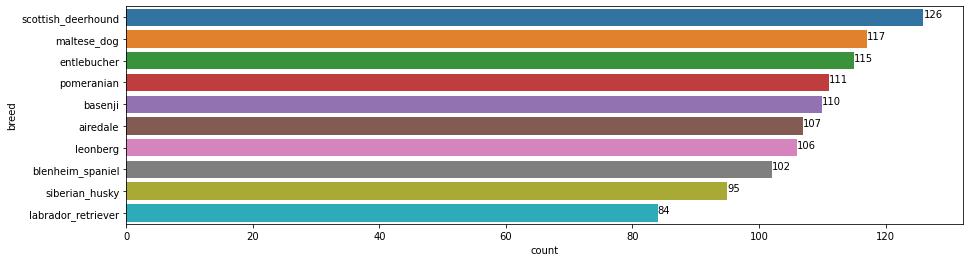

In [ ]:
#Función del longitud del bar
def barw(ax): 
    for p in ax.patches:
        val = p.get_width() #Altura del bar
        x = p.get_x() + p.get_width() 
        y = p.get_y() + p.get_height()/2 
        ax.annotate(round(val,2),(x,y))
        
#Labels de los perros
plt.figure(figsize = (15, 4))
lab = labels[labels['breed'].isin(dogs_breeds)].breed
ax0 = sns.countplot(y=lab,order=lab.value_counts().index)
barw(ax0)
plt.show()

In [5]:
#Se crean dos diccionarios para pasar las clases de forma numerica a texto.
class_dogs_breeds = {'scottish_deerhound': 0,'maltese_dog': 1,'entlebucher': 2,'pomeranian': 3,'labrador_retriever': 4,'basenji': 5,'airedale': 6,'leonberg': 7,'blenheim_spaniel': 8,'siberian_husky': 9}
class_dogs_breeds2 = {0:'scottish_deerhound',1:'maltese_dog',2:'entlebucher',3:'pomeranian',4:'labrador_retriever',5:'basenji',6:'airedale',7:'leonberg',8:'blenheim_spaniel',9:'siberian_husky'}

T = [class_dogs_breeds[item] for item in Z]
Y = to_categorical(T,10)
X = np.array(D)
X = X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

# Imagenes Aleatoria de las Razas de Perros

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

# MODELO VGG16 (RED NEURONAL)

![](https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6)* 

![](https://mlux9brz2apw.i.optimole.com/y1pDtVQ-TuEH2CPN/w:600/h:344/q:auto/https://kgptalkie.com/wp-content/uploads/2020/09/image-102.png)

58892288/58889256 [==============================] - 2s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb4b1c9a210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b1c38dd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b1c44e90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb4b1c44a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b1bbcdd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b1bc0a10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb4b1bcb090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b1bd0ed0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b0245fd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4b024ffd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb4b024f190> Fals

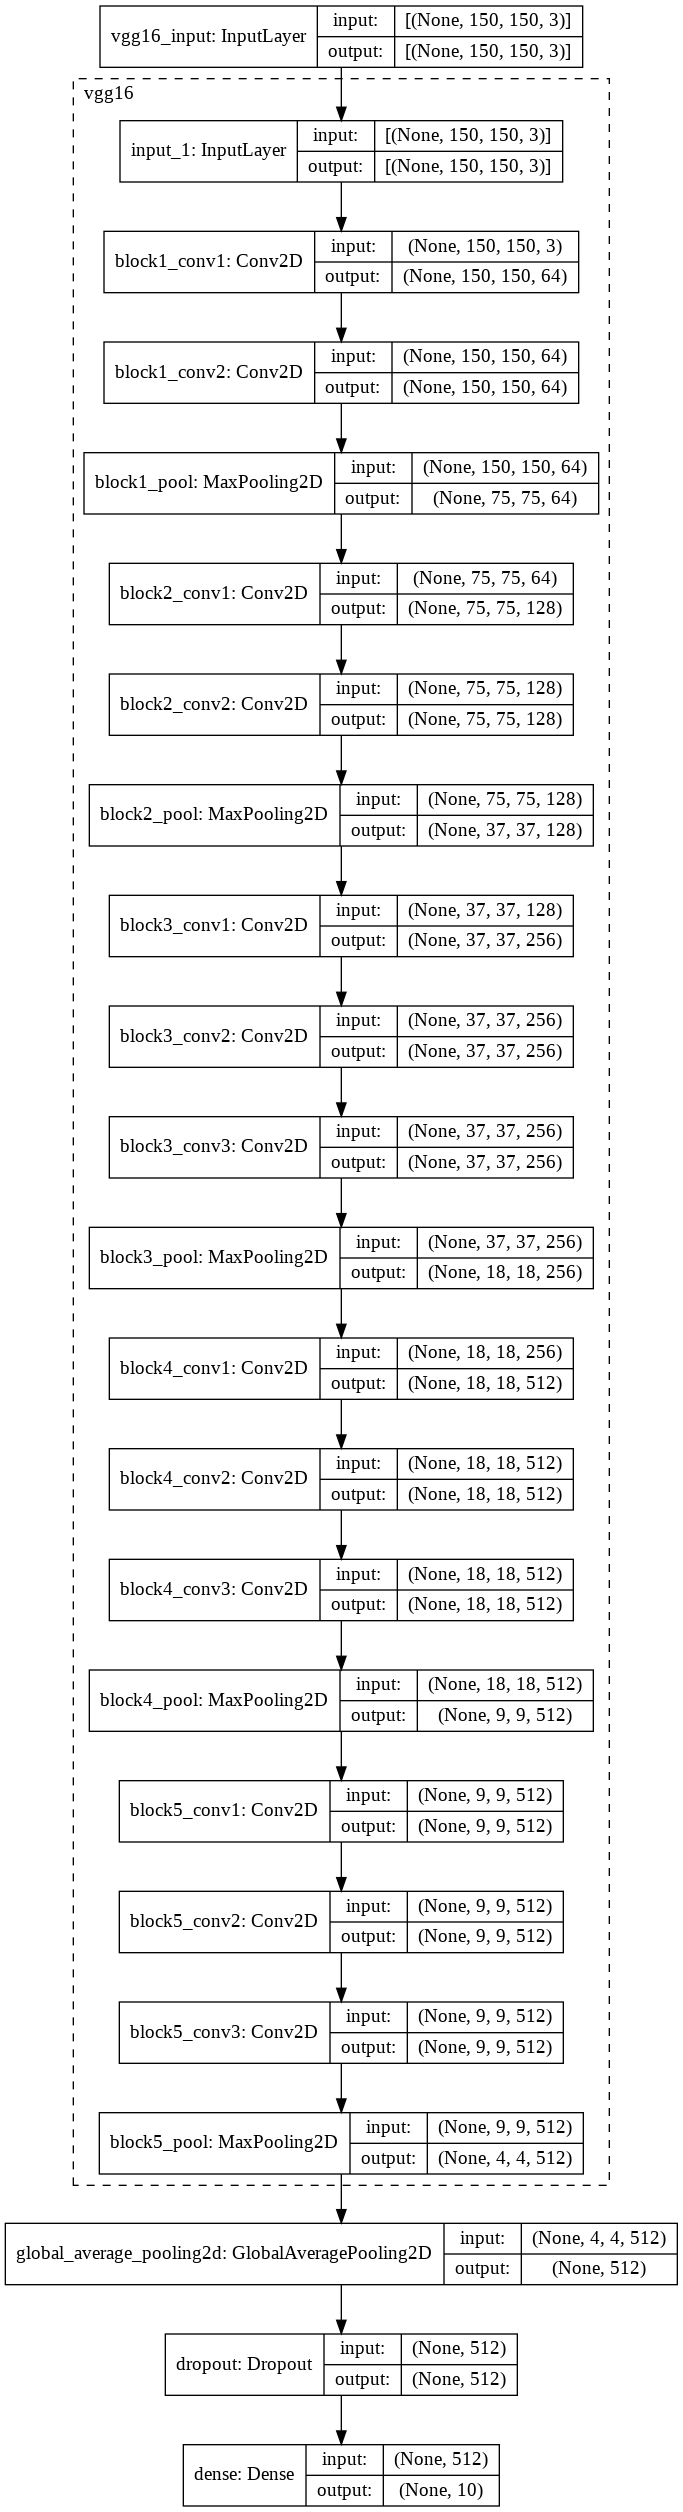

In [6]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
#Generar la instacia de ImageDataGenerator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

#Entrenamiento del Objeto ImageDataGenerator
augs_gen.fit(x_train)

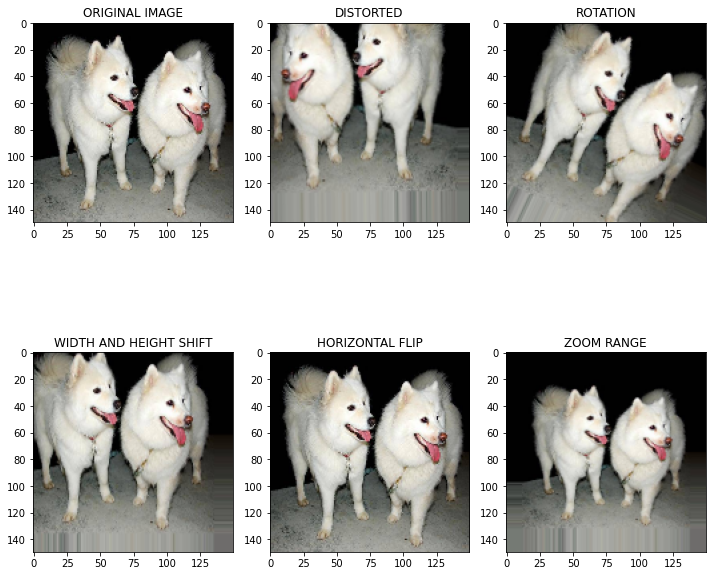

In [ ]:
#Se carga la imagen y se le hace un redimensionamiento a la imagen
path = os.path.join('dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg')
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(imgsize,imgsize))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
#Se crean los objetos de ImageDataGenerator con cada una de las caracteristicas
datagen1 = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
datagen2 = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
datagen3 = ImageDataGenerator(horizontal_flip=True, vertical_flip=False)
datagen4 = ImageDataGenerator(zoom_range=0.3)
datagen5 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

#Se saca una copia de cada imagen con la alteración de las caracteristicas.
aug_iter1 = datagen1.flow(x, batch_size=1)
aug_iter2 = datagen2.flow(x, batch_size=1)
aug_iter3 = datagen3.flow(x, batch_size=1)
aug_iter4 = datagen4.flow(x, batch_size=1)
aug_iter5 = datagen5.flow(x, batch_size=1)

#Se optiene las imagenes alteradas.
image1 = next(aug_iter1)[0].astype('uint8')
image2 = next(aug_iter2)[0].astype('uint8')
image3 = next(aug_iter3)[0].astype('uint8')
image4 = next(aug_iter4)[0].astype('uint8')
image5 = next(aug_iter5)[0].astype('uint8')

# plot imagenes
fig,ax=plt.subplots(2,3)
fig.set_size_inches(10,10)
ax[0,0].imshow(img)
ax[0,1].imshow(image5)
ax[0,2].imshow(image1)
ax[1,0].imshow(image2)
ax[1,1].imshow(image3)
ax[1,2].imshow(image4)
ax[0,0].set_title('ORIGINAL IMAGE')
ax[0,1].set_title('DISTORTED')
ax[0,2].set_title('ROTATION')
ax[1,0].set_title('WIDTH AND HEIGHT SHIFT')
ax[1,1].set_title('HORIZONTAL FLIP')
ax[1,2].set_title('ZOOM RANGE')
        
plt.tight_layout()


In [ ]:
#Prametros para el modelo:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#Entrenamiento del modelo con 20 epocas y aumento de datos
history = model.fit_generator(
    augs_gen.flow(x_train,y_train, batch_size=16),
    validation_data  = (x_test,y_test),
    epochs = 20
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
54/54 [==============================] - 209s 4s/step - loss: 2.6353 - accuracy: 0.1024 - val_loss: 2.1994 - val_accuracy: 0.2512
Epoch 2/20
54/54 [==============================] - 208s 4s/step - loss: 2.4048 - accuracy: 0.1436 - val_loss: 2.0973 - val_accuracy: 0.2884
Epoch 3/20
54/54 [==============================] - 208s 4s/step - loss: 2.2292 - accuracy: 0.1923 - val_loss: 1.9942 - val_accuracy: 0.4279
Epoch 4/20
54/54 [==============================] - 208s 4s/step - loss: 2.0766 - accuracy: 0.2843 - val_loss: 1.9221 - val_accuracy: 0.4558
Epoch 5/20
54/54 [==============================] - 208s 4s/step - loss: 2.0021 - accuracy: 0.3063 - val_loss: 1.8426 - val_accuracy: 0.5256
Epoch 6/20
54/54 [==============================] - 208s 4s/step - loss: 1.9575 - accuracy: 0.3292 - val_loss: 1.7917 - val_accuracy: 0.5256
Epoch 7/20
54/54 [==============================] - 208s 4s/step - loss: 1.8637 - accuracy: 0.3658 - val_loss: 1.7272 - val_accuracy: 0.5395
Epoch 8/20
54

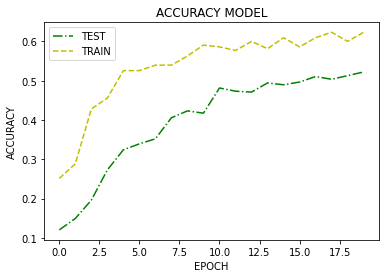

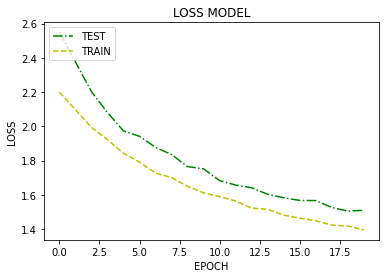

In [ ]:
plt.plot(history.history['accuracy'], linestyle='-.', color='g')
plt.plot(history.history['val_accuracy'], linestyle='--', color='y')
plt.title('ACCURACY MODEL')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TEST', 'TRAIN'], loc='upper left')

plt.show()

plt.plot(history.history['loss'], linestyle='-.', color='g')
plt.plot(history.history['val_loss'], linestyle='--', color='y')
plt.title('LOSS MODEL')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TEST', 'TRAIN'], loc='upper left')

plt.show()

valor predicho: 8
raza predicha:  blenheim_spaniel
max prob:  0.25888577
ground truth:  8
raza ground truth:  blenheim_spaniel


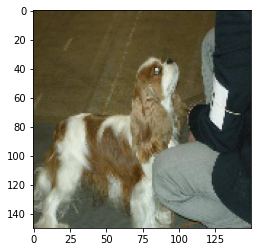

valor predicho: 2
raza predicha:  entlebucher
max prob:  0.64786273
ground truth:  2
raza ground truth:  entlebucher


valor predicho: 0
raza predicha:  scottish_deerhound
max prob:  0.5217744
ground truth:  0
raza ground truth:  scottish_deerhound


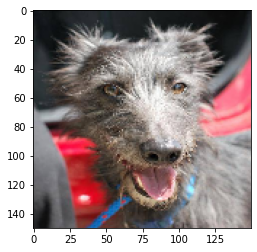

valor predicho: 2
raza predicha:  entlebucher
max prob:  0.28880495
ground truth:  2
raza ground truth:  entlebucher


valor predicho: 0
raza predicha:  scottish_deerhound
max prob:  0.6175387
ground truth:  0
raza ground truth:  scottish_deerhound


valor predicho: 5
raza predicha:  basenji
max prob:  0.5213463
ground truth:  5
raza ground truth:  basenji


valor predicho: 8
raza predicha:  blenheim_spaniel
max prob:  0.4963257
ground truth:  8
raza ground truth:  blenheim_spaniel


valor predicho: 5
raza predicha:  basenji
max prob:  0.5372235
ground truth:  5
raza ground truth:  basenji


valor predicho: 5
raza predicha:  basenji
max prob:  0.17503077
ground truth:  6
raza ground truth:  airedale


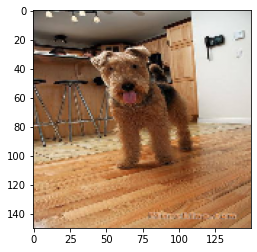

valor predicho: 1
raza predicha:  maltese_dog
max prob:  0.48175162
ground truth:  1
raza ground truth:  maltese_dog


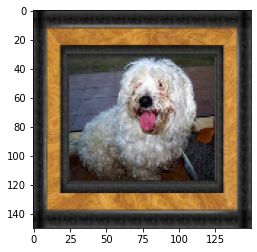

In [ ]:
list_img = np.random.randint(0,x_test.shape[0]-1,size=10)
for i,img_test in enumerate(x_test[list_img]):
    x = np.expand_dims(img_test, axis=0)
    predictions = model.predict(x)

    print("valor predicho:",  np.argmax(predictions))
    print('raza predicha: ', class_dogs_breeds2[np.argmax(predictions)])
    print("max prob: ", np.max(predictions))
    print("ground truth: ", np.argmax(y_test[list_img[i]]))
    print('raza ground truth: ', class_dogs_breeds2[np.argmax(y_test[list_img[i]])])
    plt.imshow(img_test)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
X1 = [X[i].flatten() for i in range(X.shape[0])]

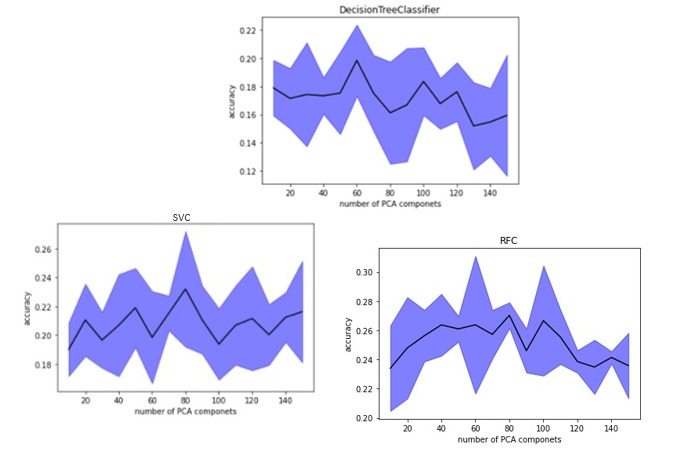

In [ ]:
#@title Clasificador SVC
#Tratamiento del clasificador SVC con PCA para el mejoramiento rendimiento
p = Pipeline((("pca", PCA(n_components=70)), ("classifier", SVC(kernel='rbf')) ))
s = cross_val_score(p, X1, T, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print( "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.302 (+/- 0.03477)


In [ ]:
#@title Clasificador RandomForestClassifier
#Tratamiento del clasificador RandomForestClassifier con PCA para el mejoramiento rendimiento
p = Pipeline((("pca", PCA(n_components=80)), ("classifier", RandomForestClassifier() )))
s = cross_val_score(p, X1, T, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print( "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.261 (+/- 0.01253)


In [ ]:
#@title Clasificador DecisiionTreeClassifier
#Tratamiento del clasificador DecisionTreeClassifier con PCA para el mejoramiento rendimiento
p = Pipeline((("pca", PCA(n_components=40)), ("classifier", DecisionTreeClassifier(max_depth = 10) )))
s = cross_val_score(p, X1, T, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print( "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.172 (+/- 0.02608)


#Concluciones


- Evidenciamos que al tener poca cantidad de imágenes se puede mejorar el accuracy mediante varias técnicas como el transfer learning y el aumento de datos.

- En este caso el mejor accuracy fue obtenido haciendo uso de una red neuronal pre entrenda VGG16, en comparación a los accuracy obtenidos mediante otros métodos.

- Las CNN dependen mucho del tamaño y la calidad de los datos de entrenamiento.

- La capacidad de reconocimiento visual de la red VGG16 junto con el aumento de datos superó las expectativas en cuanto a el accuracy esperado.